In [ ]:
!pip install simpletransformers

In [ ]:
# import torch

import os
import math
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from simpletransformers.classification import ClassificationModel, ClassificationArgs
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
# To make the output reproducible set seed to 42
# Set random seed for Python's random module
random_seed = 42
random.seed(random_seed)

# Set random seed for NumPy
np.random.seed(random_seed)

In [ ]:
OLIDv1_train_df = (pd.read_csv("olid-train-small.csv")).drop("id",axis = 1)  # length 5852
hasoc_train_df = (pd.read_csv("hasoc-train.csv")).drop("id",axis = 1)       # length 5852
OLIDv1_test_df = (pd.read_csv("olid-test.csv")).drop("id",axis = 1)         # length 860



In [ ]:
# Split the OLIDv1_train_df into input features and labels
X_olid = OLIDv1_train_df['text']
Y_olid = OLIDv1_train_df['labels']

# Split the hasoc_train_df into input features and labels
X_hasoc = hasoc_train_df['text']
Y_hasoc = hasoc_train_df['labels']

# Split the OLIDv1_train_df dataset into a training set and a validation set
X_train_olid, X_val_olid, Y_train_olid, Y_val_olid = train_test_split(X_olid, Y_olid, test_size=0.2, random_state=42)


train_olid = pd.concat([X_train_olid, Y_train_olid], axis=1)
val_olid = pd.concat([X_val_olid, Y_val_olid], axis=1)

# Split the hasoc_train_df dataset into a training set and a validation set
X_train_hasoc, X_val_hasoc, Y_train_hasoc, Y_val_hasoc = train_test_split(X_hasoc, Y_hasoc, test_size=0.2, random_state=42)

train_hasoc = pd.concat([X_train_hasoc, Y_train_hasoc], axis=1)
val_hasoc = pd.concat([X_val_hasoc, Y_val_hasoc], axis=1)

In [ ]:
# print and plot confusion matrix
def print_and_plot_confusion_matrix(true_labels, predicted_labels, experiment_name):
    cm = confusion_matrix(true_labels, predicted_labels)
    print(f'Confusion Matrix for {experiment_name}:')
    print(cm)

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    # Adjust the font size for better visualization
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['No hate', 'Hate'],
                yticklabels=['No hate', 'Hate'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {experiment_name}')
    plt.show()

In [ ]:
# calculate and print classification report
def print_classification_report(true_labels, predicted_labels, experiment_name):
    report = classification_report(true_labels, predicted_labels)
    print(f'Classification Report for {experiment_name}:')
    print(report)

In [ ]:
# def plot_losses(training_log,formatted_experiment_name):
#     plt.plot(training_log['train_loss'], label='training Loss')
#     plt.plot(training_log['eval_loss'], label='validation Loss')
#     plt.title('Training and validation loss over epochs \n'+formatted_experiment_name)
#     plt.xlabel('Evaluation Steps')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()

# Transformer based models


In [ ]:
# fine-tune and evaluate the model, then plot confusion matrix, and print classification report
def fine_tune_and_evaluate(experiment_name, train_dataset, val_dataset, test_dataset,
                           model_type, model_case, retrain=False):
    train_dataset_copy = train_dataset.copy()

    # Set up model directories and arguments
    model_directory = f"output/{model_type}/{model_case}/{experiment_name}"
    best_model_directory = model_directory + '/best_model'
    model_arguments = ClassificationArgs(output_dir=model_directory,
                                         best_model_dir=best_model_directory,
                                         save_best_model=True,
                                         reprocess_input_data = True,
                                         overwrite_output_dir=True,
                                         no_cache=True,

                                         evaluate_during_training = True,
                                         evaluate_during_training_verbose = True,
                                        #  evaluate_during_training_steps = 120,
                                        #  use_cached_eval_features = True,
                                        #  save_eval_checkpoints = True,
                                         save_model_every_epoch = False,

                                         use_early_stopping = True,
                                         early_stopping_metric = "eval_loss",
                                         early_stopping_metric_minimize = True,
                                         early_stopping_patience = 2,
                                         early_stopping_delta = 0.01,

                                        #  learning_rate= 1e-6,
                                        #  num_train_epochs=5,
                                        #  train_batch_size=32,
                                        #  eval_batch_size=32,
                                         max_seq_length = 128
                                         )

    # Train or load the model based on the existence of the model directory
    if not os.path.exists(model_directory) or retrain:
        model = ClassificationModel(model_type, model_case, args=model_arguments, use_cuda=True)
        model.train_model(train_dataset, eval_df = val_dataset)
    else:
        model = ClassificationModel(model_type, model_directory, args=model_arguments, use_cuda=True)

    # Make predictions on the test dataset
    test_predictions = model.predict(list(test_dataset.text))[0]

    # Format the experiment name for display
    formatted_experiment_name = f'{model_type}" / "{model_case}" / "{experiment_name}'

    # Print and plot confusion matrix
    print_and_plot_confusion_matrix(test_dataset.labels, test_predictions, formatted_experiment_name)

    # Print classification report
    print_classification_report(test_dataset.labels, test_predictions, formatted_experiment_name)

    #    # Load the training log
    # training_log = pd.read_csv(model_directory +"/training_progress_scores.csv")

    # # Plot the losses
    # plot_losses(training_log,formatted_experiment_name)

======================
# hateBert
======================

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for bert" / "GroNLP/hateBERT" / "in-domain-experiment:
[[562  58]
 [ 88 152]]


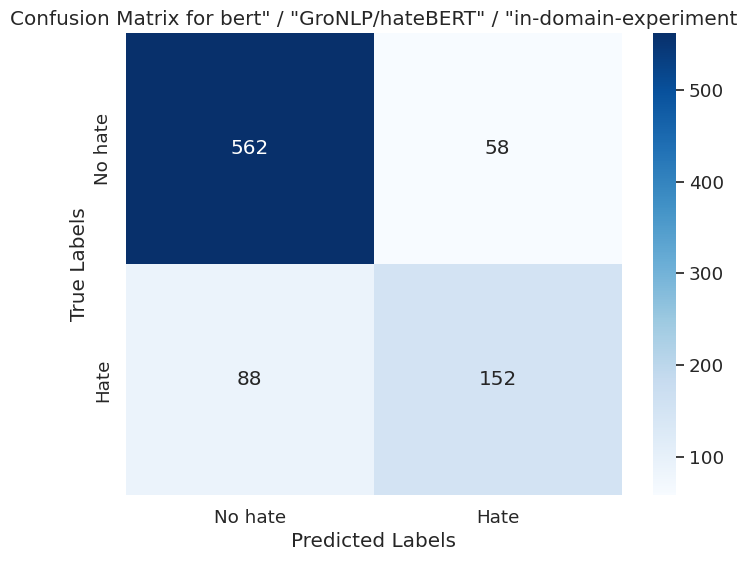

Classification Report for bert" / "GroNLP/hateBERT" / "in-domain-experiment:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       620
           1       0.72      0.63      0.68       240

    accuracy                           0.83       860
   macro avg       0.79      0.77      0.78       860
weighted avg       0.83      0.83      0.83       860



In [ ]:
# Train and evaluate the model hateBert in-domain
fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = train_olid, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type = 'bert', model_case='GroNLP/hateBERT',retrain=True)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for bert" / "GroNLP/hateBERT" / "Cross-domain-experiment:
[[571  49]
 [139 101]]


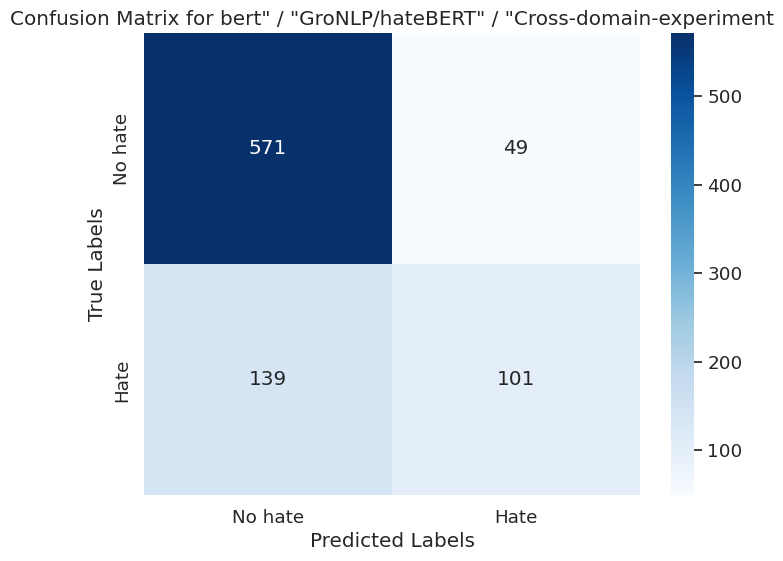

Classification Report for bert" / "GroNLP/hateBERT" / "Cross-domain-experiment:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       620
           1       0.67      0.42      0.52       240

    accuracy                           0.78       860
   macro avg       0.74      0.67      0.69       860
weighted avg       0.77      0.78      0.76       860



In [ ]:
# Train and evaluate the model hateBert Cross-domain
fine_tune_and_evaluate(experiment_name='Cross-domain-experiment',
                        train_dataset=train_hasoc, val_dataset=val_hasoc,
                       test_dataset=OLIDv1_test_df,
                       model_type = 'bert', model_case='GroNLP/hateBERT',retrain=True)


======================
# Roberta model
======================

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for roberta" / "roberta-base" / "in-domain-experiment:
[[555  65]
 [ 67 173]]


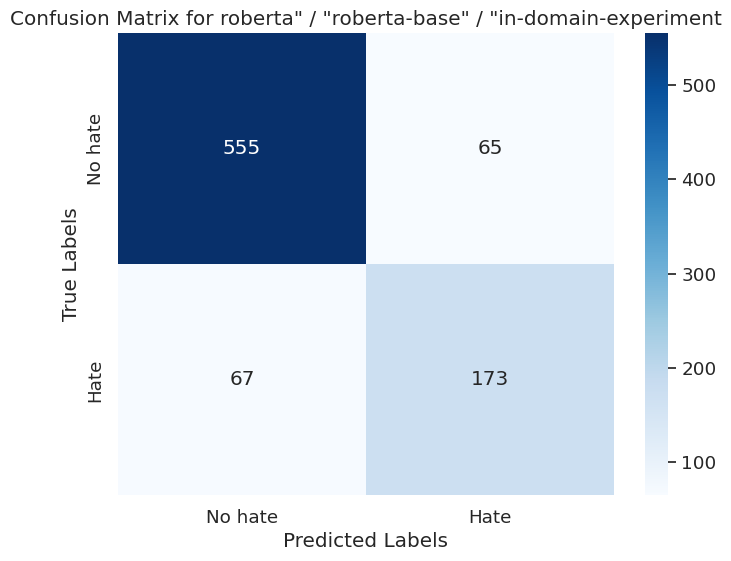

Classification Report for roberta" / "roberta-base" / "in-domain-experiment:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       620
           1       0.73      0.72      0.72       240

    accuracy                           0.85       860
   macro avg       0.81      0.81      0.81       860
weighted avg       0.85      0.85      0.85       860



In [ ]:
# Train and evaluate the model roberta in-domain

fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = train_olid, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type='roberta', model_case='roberta-base', retrain=True)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for roberta" / "roberta-base" / "Cross-domain-experiment:
[[585  35]
 [124 116]]


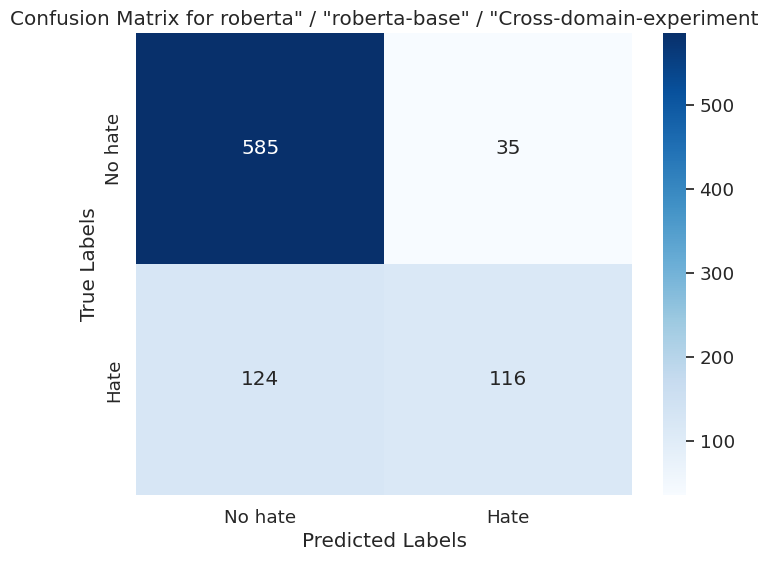

Classification Report for roberta" / "roberta-base" / "Cross-domain-experiment:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       620
           1       0.77      0.48      0.59       240

    accuracy                           0.82       860
   macro avg       0.80      0.71      0.74       860
weighted avg       0.81      0.82      0.80       860



In [ ]:
# Train and evaluate the model roberta Cross-domain

fine_tune_and_evaluate(experiment_name='Cross-domain-experiment',
                       train_dataset=train_hasoc, val_dataset=val_hasoc,
                       test_dataset=OLIDv1_test_df,
                       model_type='roberta', model_case='roberta-base', retrain=True)


======================
# other model (SVC)
======================

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from scipy.sparse import hstack
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# For Train and validation
def train_and_evaluate(X_train, Y_train, X_test, Y_test, name=None):
    # Create CountVectorizer objects
    vec_word = CountVectorizer(analyzer='word', ngram_range=(1, 1), lowercase=False)
    vec_char = CountVectorizer(analyzer='char', ngram_range=(3, 3), lowercase=False)

    # Transform the text data
    X_train = hstack((vec_word.fit_transform(X_train), vec_char.fit_transform(X_train)))
    X_test = hstack((vec_word.transform(X_test), vec_char.transform(X_test)))

    # Initialize and train the classifier
    clf_svc = LinearSVC(random_state=0)
    clf_svc.fit(X_train, Y_train)

    # Predict on the validation set
    predicted = clf_svc.predict(X_test)

    # Print classification report
    print(classification_report(Y_test, predicted))

    # Calculate and plot the confusion matrix
    cm = confusion_matrix(Y_test, predicted)
    display_labels = np.unique(Y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.title(name)
    plt.show()

    # Return the trained classifier
    return clf_svc


In [ ]:
# For Test set
def evaluate_classifier_on_test_set(classifier, X_train, olid_test,name_cm=None):
    # Create CountVectorizer objects
    vec_word = CountVectorizer(analyzer='word', ngram_range=(1, 1), lowercase=False)
    vec_char = CountVectorizer(analyzer='char', ngram_range=(3, 3), lowercase=False)

    # Fit and transform the training data
    X_train_word = vec_word.fit_transform(X_train)
    X_train_char = vec_char.fit_transform(X_train)
    X_train = hstack((X_train_word, X_train_char))

    # Transform the test data using the same vectorizers
    X_test_word = vec_word.transform(olid_test['text'])
    X_test_char = vec_char.transform(olid_test['text'])
    X_test_olid = hstack((X_test_word, X_test_char))

    # Use the trained classifier to make predictions on the test data
    predicted_test = classifier.predict(X_test_olid)

    # Print classification report for the test set
    print(classification_report(olid_test['labels'], predicted_test))

    # Calculate and plot the confusion matrix for the test set
    cm_test = confusion_matrix(olid_test['labels'], predicted_test)
    display_labels_test = np.unique(olid_test['labels'])
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels_test)
    disp_test.plot(cmap=plt.cm.Blues)
    plt.title(name_cm)
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.72      0.76      0.74       707
           1       0.60      0.55      0.57       464

    accuracy                           0.68      1171
   macro avg       0.66      0.65      0.66      1171
weighted avg       0.67      0.68      0.67      1171



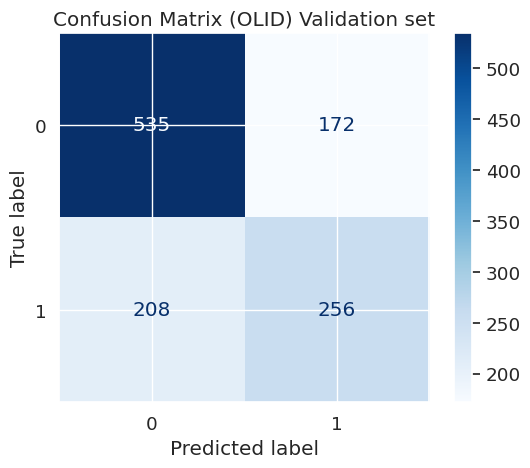

In [ ]:
# Train and validate the classifier on the in-domain (OLID) dataset
classifier_olid = train_and_evaluate(X_train_olid, Y_train_olid, X_val_olid, Y_val_olid, name = "Confusion Matrix (OLID) Validation set")

              precision    recall  f1-score   support

           0       0.81      0.73      0.76       620
           1       0.44      0.55      0.49       240

    accuracy                           0.68       860
   macro avg       0.62      0.64      0.63       860
weighted avg       0.70      0.68      0.69       860



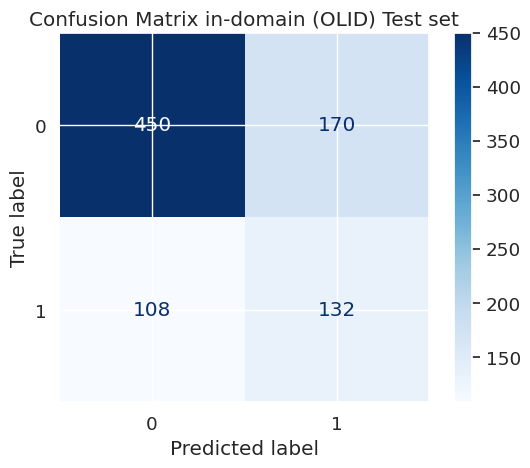

In [ ]:
# Evaluate the classifier on the in-domain (OLID-test) dataset
evaluate_classifier_on_test_set(classifier_olid, X_train_olid, OLIDv1_test_df, name_cm="SVC Confusion Matrix in-domain (OLID) Test set")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.70      0.69      0.69       734
           1       0.49      0.50      0.49       437

    accuracy                           0.62      1171
   macro avg       0.59      0.59      0.59      1171
weighted avg       0.62      0.62      0.62      1171



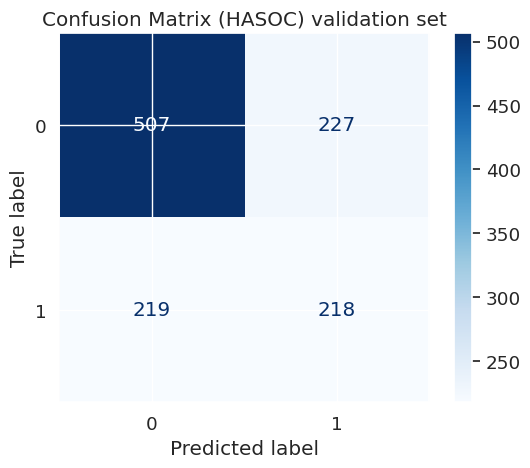

In [ ]:
# Train and validate the classifier on the HASOC dataset
classifier_hasoc = train_and_evaluate(X_train_hasoc, Y_train_hasoc, X_val_hasoc, Y_val_hasoc, name= "Confusion Matrix (HASOC) validation set")

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       620
           1       0.35      0.43      0.39       240

    accuracy                           0.62       860
   macro avg       0.55      0.56      0.56       860
weighted avg       0.64      0.62      0.63       860



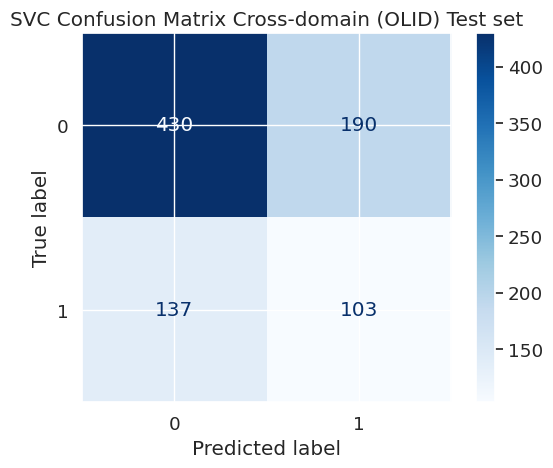

In [ ]:
# Evaluate the classifier on the coss-domain (OLID-test) dataset
evaluate_classifier_on_test_set(classifier_hasoc, X_train_hasoc, OLIDv1_test_df, name_cm="SVC Confusion Matrix Cross-domain (OLID) Test set")